In [1]:
!pip install -U transformers

## Local Inference on GPU
Model page: https://huggingface.co/google/t5-v1_1-small

⚠️ If the generated code snippets do not work, please open an issue on either the [model repo](https://huggingface.co/google/t5-v1_1-small)
			and/or on [huggingface.js](https://github.com/huggingface/huggingface.js/blob/main/packages/tasks/src/model-libraries-snippets.ts) 🙏

In [2]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("google/t5-v1_1-small")
model = AutoModelForSeq2SeqLM.from_pretrained("google/t5-v1_1-small")

model.config.num_beams = 4
model.config.num_return_sequences = 1
model.config.length_penalty = 1.0
model.config.no_repeat_ngram_size = 3


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [3]:
from datasets import load_dataset

ds = load_dataset("abisee/cnn_dailymail", "3.0.0")

In [4]:
def preprocess_function(example):

    input_text = "summarize: " + example["article"]
    target_text = example["highlights"]


    model_inputs = tokenizer(
        input_text,
        max_length=384,
        truncation=True,
        padding="max_length"
    )


    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            target_text,
            max_length=96,
            truncation=True,
            padding="max_length"
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


tokenized_dataset = ds["train"].select(range(5000)).map(preprocess_function, batched=False)


/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4006: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [5]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})


In [6]:
!pip install -q evaluate
!pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=97c2c6aee624702a579401f07e5f21fbbc6571601cffada8b490f91baaf4d0ae
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [7]:
import numpy as np
import evaluate
rouge = evaluate.load('rouge')

def _safe_ids(arr, pad_id, vocab_size=None):
    arr = np.array(arr)
    if arr.ndim == 3:
        arr = arr[:, 0, :]

    if arr.dtype.kind != 'i':
        arr = arr.astype('int64', copy=False)

    arr[arr < 0] = pad_id
    if vocab_size is not None and vocab_size > 0:
        arr = np.where(arr >= vocab_size, pad_id, arr)
    return arr

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    pad_id = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else 0
    vocab_size = getattr(tokenizer, 'vocab_size', None)

    if isinstance(preds, tuple):
        preds = preds[0]

    preds  = _safe_ids(preds,  pad_id, vocab_size)
    labels = np.array(labels)
    labels = np.where(labels != -100, labels, pad_id)
    labels = _safe_ids(labels, pad_id, vocab_size)

    decoded_preds  = tokenizer.batch_decode(preds.tolist(),  skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels.tolist(), skip_special_tokens=True)

    decoded_preds  = [p.strip() for p in decoded_preds]
    decoded_labels = [l.strip() for l in decoded_labels]

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    result = {k: round(v * 100, 4) for k, v in result.items()}
    return result


In [8]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    output_dir="./t5-small-cnn-summarizer",
    num_train_epochs=2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    logging_steps=100,
    save_steps=500,
    save_total_limit=2,
    remove_unused_columns=True,
    report_to="none",
    generation_max_length=128,
    fp16=False
)

In [9]:
val_dataset = ds["validation"].select(range(50))
tokenized_val_dataset = val_dataset.map(preprocess_function, batched=False)

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4006: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [10]:
from transformers import Seq2SeqTrainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    eval_dataset=tokenized_val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-1855562264.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [11]:
import torch
torch.cuda.empty_cache()

In [12]:
trainer.train()

Step,Training Loss
100,21.811000
200,7.827300
300,5.027600
400,4.266500
500,3.730100
600,3.470000
700,3.377500
800,3.152400
900,3.026600
1000,2.920300


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3917: UserWarning: Moving the following attributes in the config to the generation config: {'num_beams': 4, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=2500, training_loss=3.9815963012695312, metrics={'train_runtime': 495.2915, 'train_samples_per_second': 20.19, 'train_steps_per_second': 5.048, 'total_flos': 1394178785280000.0, 'train_loss': 3.9815963012695312, 'epoch': 2.0})

In [13]:
trainer.evaluate()

{'eval_loss': 1.3464562892913818,
 'eval_rouge1': 30.348,
 'eval_rouge2': 10.6694,
 'eval_rougeL': 22.1665,
 'eval_rougeLsum': 22.2353,
 'eval_runtime': 18.9989,
 'eval_samples_per_second': 2.632,
 'eval_steps_per_second': 0.684,
 'epoch': 2.0}

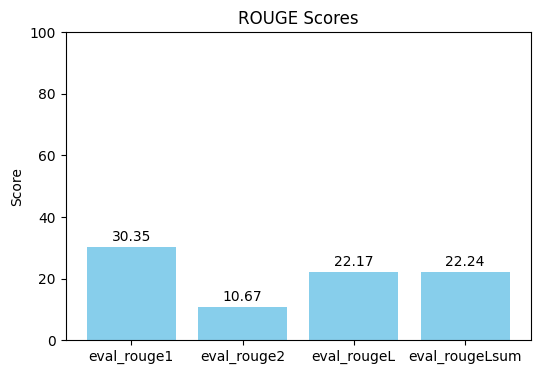

In [15]:
import matplotlib.pyplot as plt

metrics = {
    'eval_loss': 1.3465,
    'eval_rouge1': 30.348,
    'eval_rouge2': 10.6694,
    'eval_rougeL': 22.1665,
    'eval_rougeLsum': 22.2353
}

rouge_keys = ['eval_rouge1', 'eval_rouge2', 'eval_rougeL', 'eval_rougeLsum']
rouge_values = [metrics[k] for k in rouge_keys]

plt.figure(figsize=(6,4))
bars = plt.bar(rouge_keys, rouge_values, color='skyblue')
plt.ylabel('Score')
plt.ylim(0, 100)
plt.title('ROUGE Scores')

for bar, val in zip(bars, rouge_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{val:.2f}', ha='center', va='bottom')

plt.show()


In [16]:

import os, time, psutil, torch, numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()


def pick_texts(n=64):
    try:
        cols = getattr(val_dataset, "column_names", [])
        col = next((c for c in ["input_text","text","article","content","src"] if c in cols), None)
        if col is None: raise KeyError
        xs = [val_dataset[i][col] for i in range(min(n, len(val_dataset)))]
        if not xs: raise KeyError

        return (xs * (n // len(xs) + 1))[:n]
    except Exception:
        return ["This is a short sentence for timing."] * n

def encode(texts):
    enc = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    return {k: v.to(device) for k, v in enc.items()}

@torch.inference_mode()
def run_batch(bs, repeats=10, warmup=3, max_new_tokens=6, gen_kwargs=None):
    if gen_kwargs is None:
        gen_kwargs = dict(num_beams=4, early_stopping=True)
    texts  = pick_texts(bs)
    inputs = encode(texts)


    max_length = int(inputs["input_ids"].size(1) + max_new_tokens)

    if device.type == "cuda":
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()


    for _ in range(warmup):
        _ = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs.get("attention_mask"),
            max_length=max_length, **gen_kwargs
        )
        if device.type == "cuda": torch.cuda.synchronize()


    times = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        _ = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs.get("attention_mask"),
            max_length=max_length, **gen_kwargs
        )
        if device.type == "cuda": torch.cuda.synchronize()
        times.append(time.perf_counter() - t0)


    gpu_cur = gpu_peak = None
    if device.type == "cuda":
        gpu_cur  = torch.cuda.memory_allocated() / (1024**2)      # MB
        gpu_peak = torch.cuda.max_memory_allocated() / (1024**2)  # MB
    cpu_mb = psutil.Process(os.getpid()).memory_info().rss / (1024**2)

    return dict(
        bs=bs,
        avg_s=float(np.mean(times)),
        p50_s=float(np.median(times)),
        p90_s=float(np.percentile(times, 90)),
        gpu_cur_mb=None if gpu_cur is None else round(gpu_cur, 2),
        gpu_peak_mb=None if gpu_peak is None else round(gpu_peak, 2),
        cpu_mb=round(cpu_mb, 2),
    )

def safe_run(bs):
    try:
        return run_batch(bs)
    except RuntimeError as e:
        if "out of memory" in str(e).lower():
            if device.type == "cuda": torch.cuda.empty_cache()
            return dict(bs=bs, avg_s=None, OOM=True)
        raise


single = safe_run(1)
b1  = single
b8  = safe_run(8)
b16 = safe_run(16)
b32 = safe_run(32)

def fmt_ms(v): return "OOM" if (v is None) else f"{v*1000:.2f} ms"

print("=== Metrics ===")
print(f"Average Inference Latency (single input): {fmt_ms(b1['avg_s'])}")
print(f"GPU Memory (Current Allocated): {b1.get('gpu_cur_mb','N/A')} MB")
print(f"GPU Memory (Peak Allocated):    {b1.get('gpu_peak_mb','N/A')} MB")
print(f"CPU Memory Usage: {b1.get('cpu_mb','N/A')} MB")
print(f"Batch Size 1  Latency: {fmt_ms(b1['avg_s'])}")
print(f"Batch Size 8  Latency: {fmt_ms(b8.get('avg_s'))}")
print(f"Batch Size 16 Latency: {fmt_ms(b16.get('avg_s'))}")
print(f"Batch Size 32 Latency: {fmt_ms(b32.get('avg_s'))}")


=== Metrics ===
Average Inference Latency (single input): 471.08 ms
GPU Memory (Current Allocated): 900.99 MB
GPU Memory (Peak Allocated):    961.81 MB
CPU Memory Usage: 2937.74 MB
Batch Size 1  Latency: 471.08 ms
Batch Size 8  Latency: 1417.08 ms
Batch Size 16 Latency: 2101.95 ms
Batch Size 32 Latency: 3963.33 ms
